# "Garbage Model"

In this notebook, we try a "_garbage model_" approach: instead of _predicting_ languages, we just try to _validate_ that a sentence is actually Swiss German. 

We put all non SG sentence into the same class and run our prediction pipeline as usual.

In [1]:
%run notebook_utils.py
%run gridsearch_utils.py

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
import matplotlib

# set big font in plots
SMALL_SIZE = 16
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

In [4]:
%cd ..
from langid import sanitize, np_sanitize
%cd -

/Users/Lin/git/SwigSpot/language-detection
/Users/Lin/git/SwigSpot/language-detection/notebooks


In [5]:
# load the data
X_train, X_test, y_train, y_test = load_split_data()
sms_any_X, sms_any_y = load_sms_any()

# transform the labels: 0 => non SG, 1 => SG
labels = ['Not SG', 'SG']
labels_train = np.array(y_train == 4, dtype=np.int)
labels_test = np.array(y_test == 4, dtype=np.int)
labels_any = np.array(sms_any_y == 4, dtype=np.int)

# Basic pipe: TfidfVectorizer + LogisticRegression

In this first try, we do nothing special.

In [6]:
%%time

pipe = Pipeline(steps=[
    ('vec', TfidfVectorizer(ngram_range=(3,5), analyzer='char', use_idf=False, max_features=6000)),
    ('clf', LogisticRegression())
])


pipe.fit(X_train, labels_train)
predicted = pipe.predict(X_test)

CPU times: user 11 s, sys: 326 ms, total: 11.3 s
Wall time: 11.3 s


TEST SET
accuracy: 0.9909

             precision    recall  f1-score   support

     Not SG     0.9935    0.9953    0.9944      5950
         SG     0.9804    0.9729    0.9766      1438

avg / total     0.9909    0.9909    0.9909      7388



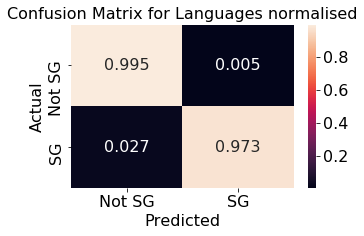

SMS RECALL
SMS recall: 97.67%
SMS errors: 249 / 10692 (2.33%)



VALIDATION SET
accuracy: 0.9095

             precision    recall  f1-score   support

     Not SG     0.9986    0.8881    0.9401       804
         SG     0.6897    0.9950    0.8147       201

avg / total     0.9368    0.9095    0.9150      1005



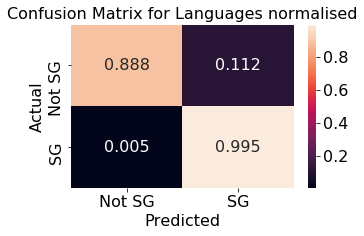

In [7]:
print("TEST SET")
print("========")

print_results(labels_test, predicted, labels=labels)
plot_confusion_matrix(labels_test, predicted, normalised=True, labels=labels, figsize=(5,3))

print("SMS RECALL")
print("==========")

sms_predicted = pipe.predict(sms_sg)
print("SMS recall: %.2f%%" % (sms_predicted.sum() / sms_predicted.size * 100))
num_errors = sms_predicted.size - sms_predicted.sum()
print("SMS errors: %d / %d (%.2f%%)\n" % (num_errors, sms_predicted.size, num_errors / sms_predicted.size * 100))

print("\n\nVALIDATION SET")
print("===============")
sms_any_predicted = pipe.predict(sms_any_X)
print_results(labels_any, sms_any_predicted, labels=labels)
plot_confusion_matrix(labels_any, sms_any_predicted, normalised=True, labels=labels, figsize=(5,3))


# Same, but with sanitization

In [8]:
%%time

pipe = Pipeline(steps=[
    ('vec', TfidfVectorizer(ngram_range=(3,5), analyzer='char', use_idf=False, max_features=6000)),
    ('clf', LogisticRegression())
])


pipe.fit(np_sanitize(X_train), labels_train)
predicted = pipe.predict(X_test)

CPU times: user 10.2 s, sys: 342 ms, total: 10.6 s
Wall time: 10.6 s


TEST SET
accuracy: 0.9896

             precision    recall  f1-score   support

     Not SG     0.9925    0.9946    0.9935      5950
         SG     0.9775    0.9687    0.9731      1438

avg / total     0.9896    0.9896    0.9896      7388



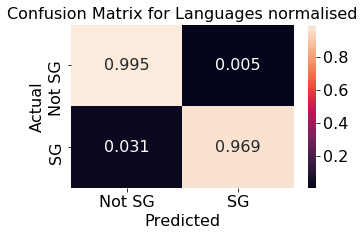

SMS RECALL
SMS recall: 97.35%
SMS errors: 283 / 10692 (2.65%)



VALIDATION SET
accuracy: 0.9154

             precision    recall  f1-score   support

     Not SG     0.9972    0.8968    0.9443       804
         SG     0.7057    0.9900    0.8240       201

avg / total     0.9389    0.9154    0.9203      1005



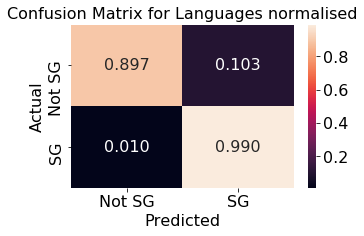

In [9]:
print("TEST SET")
print("========")

print_results(labels_test, predicted, labels=labels)
plot_confusion_matrix(labels_test, predicted, normalised=True, labels=labels, figsize=(5,3))

print("SMS RECALL")
print("==========")

sms_predicted = pipe.predict(np_sanitize(sms_sg))
print("SMS recall: %.2f%%" % (sms_predicted.sum() / sms_predicted.size * 100))
num_errors = sms_predicted.size - sms_predicted.sum()
print("SMS errors: %d / %d (%.2f%%)\n" % (num_errors, sms_predicted.size, num_errors / sms_predicted.size * 100))

print("\n\nVALIDATION SET")
print("===============")
sms_any_predicted = pipe.predict(np_sanitize(sms_any_X))
print_results(labels_any, sms_any_predicted, labels=labels)
plot_confusion_matrix(labels_any, sms_any_predicted, normalised=True, labels=labels, figsize=(5,3))


# Using only Swiss German features 

In [10]:
%%time

pipe = Pipeline(steps=[
    ('vec', TfidfVectorizer(ngram_range=(3,5), analyzer='char', use_idf=False, max_features=6000)),
    ('clf', LogisticRegression())
])

sg_idx = np.where(labels_train == 1)
pipe.named_steps['vec'].fit(X_train[sg_idx], labels_train[sg_idx])

pipe.named_steps['clf'].fit(pipe.named_steps['vec'].transform(X_train), labels_train)
predicted = pipe.predict(X_test)

CPU times: user 8.41 s, sys: 136 ms, total: 8.55 s
Wall time: 8.56 s


TEST SET
accuracy: 0.9916

             precision    recall  f1-score   support

     Not SG     0.9940    0.9956    0.9948      5950
         SG     0.9818    0.9750    0.9784      1438

avg / total     0.9916    0.9916    0.9916      7388



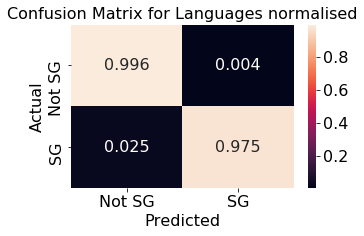

SMS RECALL
SMS recall: 97.80%
SMS errors: 235 / 10692 (2.20%)



VALIDATION SET
accuracy: 0.8955

             precision    recall  f1-score   support

     Not SG     0.9986    0.8706    0.9302       804
         SG     0.6579    0.9950    0.7921       201

avg / total     0.9304    0.8955    0.9026      1005



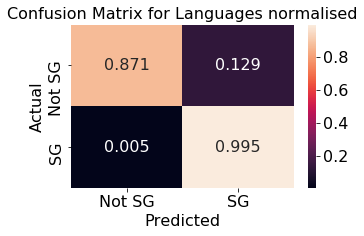

In [11]:
print("TEST SET")
print("========")

print_results(labels_test, predicted, labels=labels)
plot_confusion_matrix(labels_test, predicted, normalised=True, labels=labels, figsize=(5,3))

print("SMS RECALL")
print("==========")

sms_predicted = pipe.predict(sms_sg)
print("SMS recall: %.2f%%" % (sms_predicted.sum() / sms_predicted.size * 100))
num_errors = sms_predicted.size - sms_predicted.sum()
print("SMS errors: %d / %d (%.2f%%)\n" % (num_errors, sms_predicted.size, num_errors / sms_predicted.size * 100))

print("\n\nVALIDATION SET")
print("===============")
sms_any_predicted = pipe.predict(sms_any_X)
print_results(labels_any, sms_any_predicted, labels=labels)
plot_confusion_matrix(labels_any, sms_any_predicted, normalised=True, labels=labels, figsize=(5,3))